# 2 - Products similarities
No pre-trained models allowed

In [6]:
!pip install -q scipy==1.15.3 pandas==2.2.3 rouge-score==0.1.2 unidecode==1.4.0 watermark

In [7]:
%reload_ext watermark

In [8]:
import re
import time
import numpy as np
import pandas as pd
from itertools import product
from unidecode import unidecode
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from rouge_score.rouge_scorer import RougeScorer

%watermark --iversions

scipy      : 1.15.3
re         : 2.2.1
matplotlib : 3.10.0
numpy      : 2.0.2
rouge_score: 0.1.2
google     : 2.0.3
pandas     : 2.2.3
unidecode  : 1.4.0



In [9]:
items = pd.read_csv("items_titles.csv")
items_test = pd.read_csv("items_titles_test.csv")
items

,ITE_ITEM_TITLE
0,Tênis Ascension Posh Masculino - Preto E Verme...
1,Tenis Para Caminhada Super Levinho Spider Corr...
2,Tênis Feminino Le Parc Hocks Black/ice Origina...
3,Tênis Olympikus Esportivo Academia Nova Tendên...
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicl...
...,...
29995,Tênis Vans Old Skool I Love My Vans - Usado - ...
29996,Tênis Feminino Preto Moleca 5296155
29997,Tenis Botinha Com Pelo Via Marte Original Lanç...
29998,Tênis Slip On Feminino Masculino Original Sapa...


In [10]:
items_test

,ITE_ITEM_TITLE
0,Tênis Olympikus Esporte Valente - Masculino Kids
1,Bicicleta Barra Forte Samy C/ 6 Marchas Cubo C...
2,Tênis Usthemp Slip-on Temático - Labrador 2
3,Tênis Casual Feminino Moleca Tecido Tie Dye
4,Tênis Star Baby Sapatinho Conforto + Brinde
...,...
9995,Chuteira Futsal Oxn Velox 3 Infantil
9996,Sapatenis Casual Masculino Estiloso 24horas Co...
9997,Tênis Feminino Infantil Molekinha Tie Dye
9998,Tênis Feminino Leve Barato Ganhe 1 Colchonete ...


In [11]:
items.columns = [c.lower() for c in items.columns]
items_test.columns = [c.lower() for c in items.columns]

# EDA

In [12]:
# Let's evaluate if there is any NULL values
items.ite_item_title.isna().sum()

np.int64(0)

In [13]:
# Let's see the first word of each product
# Some words have accent
items.ite_item_title.str.lower().str.split(" ").apply(lambda x: x[0]).value_counts().head(10)

,count
ite_item_title,
tênis,15895
tenis,4634
bicicleta,2100
sapatênis,1066
kit,771
sapatilha,750
sapatenis,581
tv,359
sapato,259


In [14]:
# There are some items starting with ''?
items.ite_item_title.str.lower().apply(unidecode).str.split(" ").apply(lambda x: x[0]).value_counts().head(10)

,count
ite_item_title,
tenis,20566
bicicleta,2100
sapatenis,1648
kit,771
sapatilha,750
tv,359
sapato,259
bike,229
,178


In [15]:
items.ite_item_title.str.lower().apply(unidecode).str.split(" ").pipe(lambda x: x[x.apply(lambda y: y[0]) == ''])

,ite_item_title
269,"[, tenis, polo, plus, masculino, varias, cores..."
271,"[, tenis, bull, terrier, bruce, low, -, , boto..."
362,"[, tenis, feminino, casual, tie, dye, acompanh..."
392,"[, bicicleta, aro29, avance, inception, 21v, s..."
422,"[, slip, casual, infantil, menino, azul, pimpo..."
...,...
29503,"[, tenis, olympikus, proof, feminino, original..."
29687,"[, sapatenis, casual, qualidade, em, 1, lugar,..."
29752,"[, tenis, unissex, casual, cadarco, chuck, tay..."
29904,"[, tenis, floral, infantil, estampado, molekin..."


In [16]:
# Let's strip values
items.assign(new_value=lambda x: x.ite_item_title.str.lower().apply(unidecode).str.strip())\
    .new_value.str.split(" ").apply(lambda x: x[0]).value_counts().head(20)

,count
new_value,
tenis,20667
bicicleta,2106
sapatenis,1669
kit,779
sapatilha,750
tv,362
sapato,261
bike,230
smart,174


In [17]:
# Different start words
items.assign(new_value=lambda x: x.ite_item_title.str.lower().apply(unidecode).str.strip())\
    .new_value.str.split(" ").apply(lambda x: x[0]).value_counts()

,count
new_value,
tenis,20667
bicicleta,2106
sapatenis,1669
kit,779
sapatilha,750
...,...
sapateni,1
exclusiva,1
beach,1


In [18]:
# How many different words does this dataset have?
items_ = items.assign(new_value=lambda x: x.ite_item_title.str.lower().apply(unidecode).str.strip())
items_.new_value.str.split(" ").explode().nunique()

19229

In [19]:
items_.new_value.str.split(" ").explode().drop_duplicates()

,new_value
0,tenis
0,ascension
0,posh
0,masculino
0,-
...,...
29984,solarhu
29984,(ultraboost)
29985,hajime
29992,javelin


In [20]:
items_.new_value.str.split(" ").explode()\
    .drop_duplicates().pipe(lambda x: x[x.apply(lambda y: "ultraboost" in y)])

,new_value
5882,ultraboost
29984,(ultraboost)


In [21]:
# Let's remove non alpha numeric characters
items_.new_value.str.split(" ").explode()\
    .str.replace(r'[^a-zA-Z0-9 ]', '', regex=True)\
    .drop_duplicates().pipe(lambda x: x[x.apply(lambda y: "ultraboost" in y)])

,new_value
5882,ultraboost


In [22]:
items_ = items.assign(new_value=lambda x:
                      x.ite_item_title
                      .str.lower()
                      .apply(unidecode)
                      .str.strip()
                      .str.replace(r'[^a-zA-Z0-9 ]', '', regex=True))

In [23]:
# Not using default stopwords list (like nltk), because some stopwords may change
# the meaning of the title. Like the word 'sem' or 'com'
my_stopwords = ["e", "a", "o", "as", "os", "para"]

In [24]:
# Removing stopwords
def remove_stopwords(text: str, stopwords: list):
    tokens = re.findall(r'\b\w+\b', text)
    return " ".join([t for t in tokens if t not in stopwords])

items_ = items.assign(new_value=lambda x:
                      x.ite_item_title
                      .str.lower()
                      .apply(unidecode)
                      .str.strip()
                      .str.replace(r'[^a-zA-Z0-9 ]', '', regex=True)
                      .apply(remove_stopwords,
                             stopwords=my_stopwords))

In [25]:
def rouge_metric(row: pd.Series):
    if row.text1 == row.text2:
        return 1.0
    else:
        return RougeScorer(["rouge1"]).score(target=row.text1, prediction=row.text2)["rouge1"].precision

# List similarity method

In [26]:
def similarity_list(df: pd.DataFrame,
                    stopwords: list,
                    column: str = "ite_item_title"):
    df_ = df.assign(new_value=lambda x:
              x[column]
              .str.lower()
              .apply(unidecode)
              .str.strip()
              .str.replace(r'[^a-zA-Z0-9 ]', '', regex=True)
              .apply(remove_stopwords,
                     stopwords=stopwords))
    map_ = df_.drop_duplicates().set_index("new_value")[column].to_dict()
    return pd.DataFrame.from_records(product(df_.new_value, df_.new_value),
                          columns=["text1", "text2"])\
        .assign(score=lambda x:
                x.apply(rouge_metric, axis=1))\
        .replace(map_)

In [27]:
similarity_list(items_test.iloc[:20], stopwords=my_stopwords)

,text1,text2,score
0,Tênis Olympikus Esporte Valente - Masculino Kids,Tênis Olympikus Esporte Valente - Masculino Kids,1.000000
1,Tênis Olympikus Esporte Valente - Masculino Kids,Bicicleta Barra Forte Samy C/ 6 Marchas Cubo C...,0.000000
2,Tênis Olympikus Esporte Valente - Masculino Kids,Tênis Usthemp Slip-on Temático - Labrador 2,0.166667
3,Tênis Olympikus Esporte Valente - Masculino Kids,Tênis Casual Feminino Moleca Tecido Tie Dye,0.142857
4,Tênis Olympikus Esporte Valente - Masculino Kids,Tênis Star Baby Sapatinho Conforto + Brinde,0.166667
...,...,...,...
395,Tênis Feminino Luana Têxtil Malu Super Comfort...,Sapatênis Couro Legítimo Forrado Em Couro Sola...,0.000000
396,Tênis Feminino Luana Têxtil Malu Super Comfort...,Tenis Feminino Casual Chunky Vizzano Dad Sneak...,0.250000
397,Tênis Feminino Luana Têxtil Malu Super Comfort...,Tênis Fila D-formation - Feminino,0.500000
398,Tênis Feminino Luana Têxtil Malu Super Comfort...,Tênis Infantil Pé Com Pé Masculino Calce Fácil...,0.200000


# Execution time

In [30]:
x = np.arange(50, 1000, 50)
y = []
for i in x:
    print(i)
    start = time.time()
    similarity_list(items.iloc[:i], stopwords=my_stopwords)
    y.append(time.time() - start)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


Text(0, 0.5, 'Execution time (seconds)')

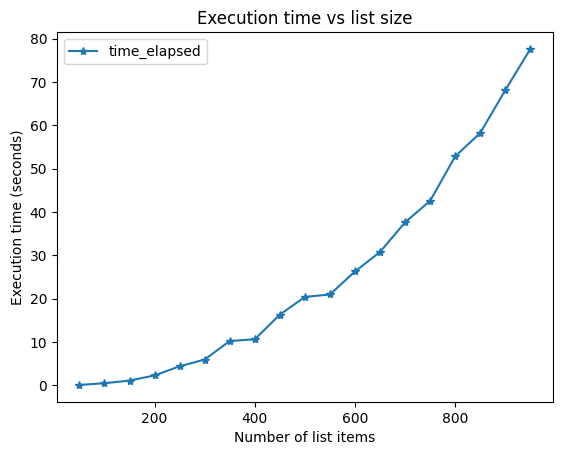

In [31]:
ax = plt.figure().gca()
pd.DataFrame({"n_items": x,
              "time_elapsed": y})\
    .plot(kind="line",
          x="n_items",
          y="time_elapsed",
          ax=ax,
          marker="*",
          title="Execution time vs list size")
ax.set_xlabel("Number of list items")
ax.set_ylabel("Execution time (seconds)")

In [33]:
projection_coeficients = curve_fit(lambda t,a,b: a + b*np.log(t),  x,  np.log(y))[0]

<Axes: title={'center': 'Execution time vs list size'}, xlabel='n_items'>

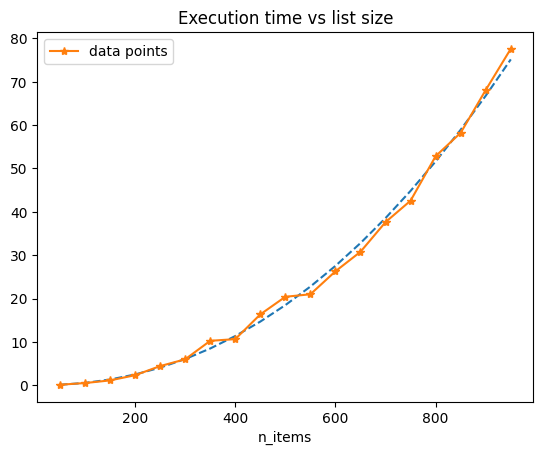

In [34]:
# Fit?
ax = plt.figure().gca()
ax.plot(x, np.exp(projection_coeficients[0] + projection_coeficients[1]*np.log(x)),
        label="projection",
        linestyle="--")
pd.DataFrame({"n_items": x,
              "time_elapsed": y})\
    .plot(kind="line",
          x="n_items",
          y="time_elapsed",
          ax=ax,
          label="data points",
          marker="*",
          title="Execution time vs list size",
          color="C1")

Text(5000.0, 11577.394917738615, '3.6 hours expected')

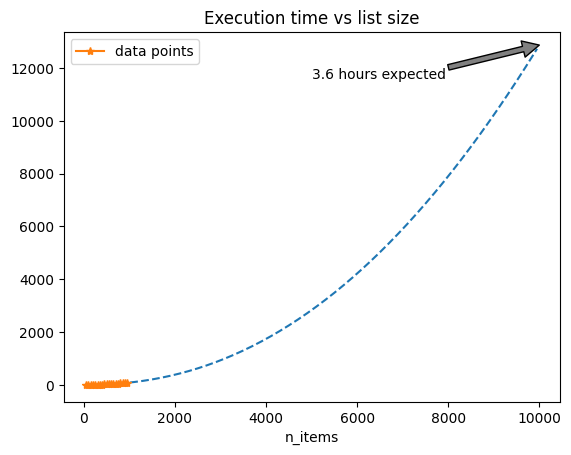

In [35]:
# Projection
ax = plt.figure().gca()
x_ = np.arange(50, 10000, 50)
y_ = np.exp(projection_coeficients[0] + projection_coeficients[1]*np.log(x_))
ax.plot(x_, y_, label="projection", linestyle="--")
pd.DataFrame({"n_items": x,
              "time_elapsed": y})\
    .plot(kind="line",
          x="n_items",
          y="time_elapsed",
          ax=ax,
          label="data points",
          marker="*",
          title="Execution time vs list size",
          color="C1")
final_projection_hours = np.exp(projection_coeficients[0] + projection_coeficients[1]*np.log(items_test.shape[0]))/3600
plt.annotate(text="%.1f hours expected" % final_projection_hours,
             xy=(items_test.shape[0], final_projection_hours*3600),
             arrowprops=dict(facecolor='gray'),
             xytext=(items_test.shape[0]*.5, final_projection_hours*3600*.9))

# Conclusion

As the number of items increases (list size), the time required to compute similarities becomes impractical. Performing text embedding and using a vector database could be a more efficient and scalable solution.